# Analysis of the Kohn-Sham driving dataset

## First case: single periodic driving $h_i (t)=0.5J cos(\omega t)+ a_i$

### Dataset analysis

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Parameters

In [9]:
data=np.load('data/dataset_h_eff/periodic/dataset_periodic_random_rate_0-1_nbatch_100_batchsize_1000_steps_200_tf_20.0_l_8_240229.npz')

z=data['z']
h_eff=data['h_eff']
h=data['h']

time=np.linspace(0,20,h.shape[1])

print(f'ndata={h.shape[0]} \n time steps={h.shape[1]} \n')


ndata=100000 
 time steps=200 



#### Histogram of the values

This procedure has been used in the static DFT case to check which range of values is explored by the magnetization. Remember that the magnetization space can be explored just by varying the driving.

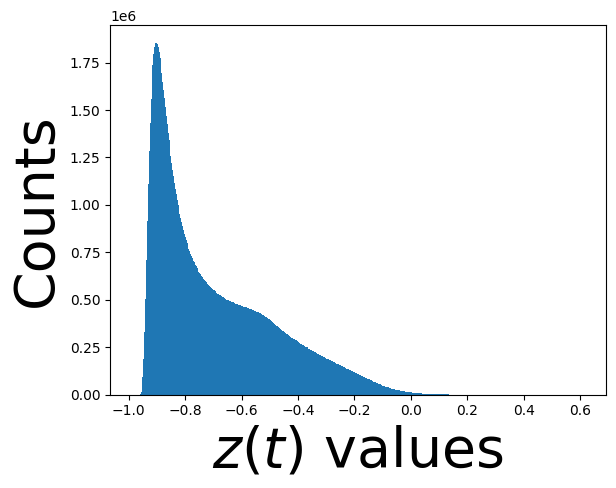

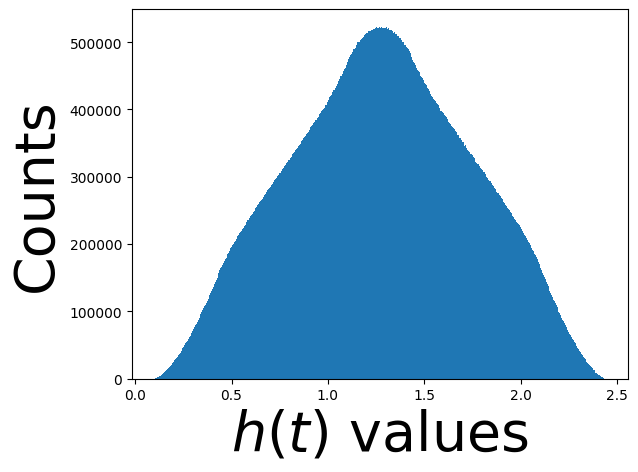

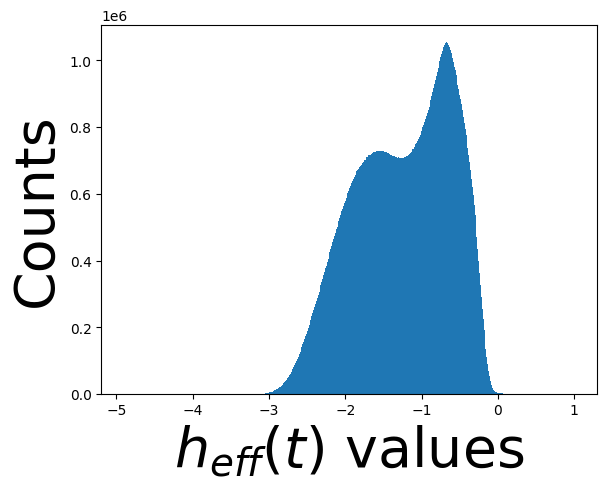

In [3]:
plt.hist(z[:85000].reshape(-1),bins=500)
plt.xlabel(r'$z(t)$ values',fontsize=40)
plt.ylabel('Counts',fontsize=40)
plt.show()

plt.hist(h[:85000].reshape(-1),bins=500)
plt.xlabel(r'$h(t)$ values',fontsize=40)
plt.ylabel('Counts',fontsize=40)
plt.show()

plt.hist(h_eff[:85000].reshape(-1),bins=500)
plt.xlabel(r'$h_{eff}(t)$ values',fontsize=40)
plt.ylabel('Counts',fontsize=40)
plt.show()

#### Random Samples

We want to see some random samples to check the behaviour of the dynamics.

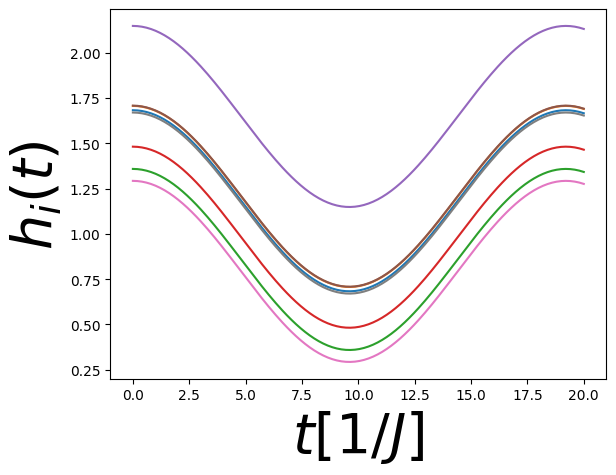

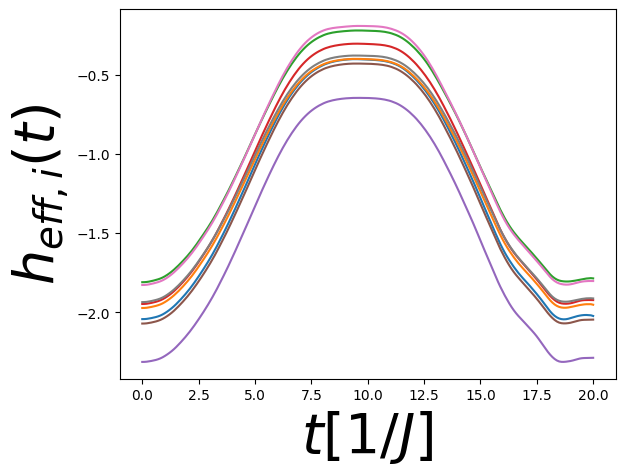

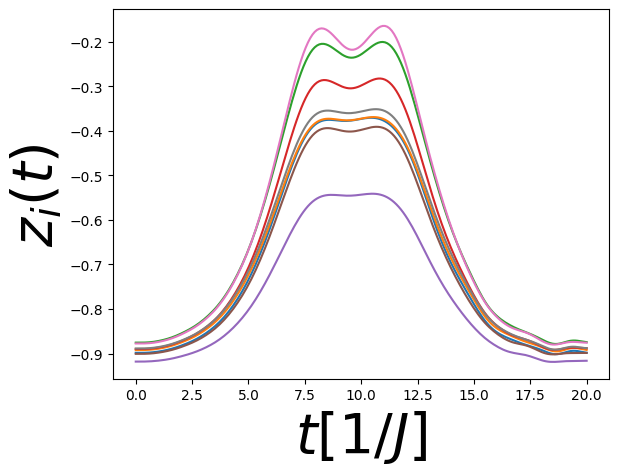

In [4]:
idx=np.random.randint(0,85000)

for i in range(h.shape[-1]):
    plt.plot(time,h[idx,:,i])
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$h_i(t)$',fontsize=40)
plt.show()


for i in range(h.shape[-1]):
    plt.plot(time,h_eff[idx,:,i])
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$h_{eff,i}(t)$',fontsize=40)
plt.show()


for i in range(h.shape[-1]):
    plt.plot(time,z[idx,:,i])
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$z_i(t)$',fontsize=40)
plt.show()

#### Check any NAN in the dataset

The computation of the $h_{eff}(t)$ driving may suffer discontinuous behaviours, due to the rapid evolution of both the magnetization current and the magnetization and due to the small time steps. For this reason we need to double check if NAN values occur.

In [5]:
nan_indices = np.where(np.isnan(h_eff))[0]
print('indices of the samples affected by the NAN=',nan_indices,'\n')


indices of the samples affected by the NAN= [] 



#### Create a puntual $z_i(t) \rightarrow h_{eff,i}(t)-h(t)$ dataset

Following the paper "Machine-learning Kohn–Sham potential from dynamics in time-dependent Kohn–Sham systems" DOI:10.1088/2632-2153/ace8f0 , we create a dataset of punctual mappings between the magnetization and the effective field 

In [12]:
ndata=5000
#we take steps every 20 time steps
z_punctual=z[:ndata,::20].reshape(-1,z.shape[-1])
# we need to fix h_eff-h because our Kohn sham system is fixed by h(t)
h_eff_punctual=(h_eff[:ndata,::20]-h[:ndata,::20]).reshape(-1,z.shape[-1])

#we save the dataset
print('total data=',z_punctual.shape[0],'\n')

np.savez(f'data/dataset_h_eff/train_punctual_dataset_{z_punctual.shape[0]}',density=z_punctual,potential=h_eff_punctual)


total data= 50000 



#### Fourier transform and analysis of the spectrum

It is still unclear how we can map the Kohn-Sham driving to the Many-body dynamics. A possible strategy is to follow the Quantum computer solver in the paper DOI:10.1088/1367-2630/16/8/083035 "Computational complexity of time-dependent density functional theory" and mapping $h(t) \rightarrow h_{eff}(t)$. In order to do that, because we are dealing with continous system, the best approach is via the spectrum analysis. Therefore we investigate the spectrum of these observables and we create a dataset based on this

##### Fourier transform

In [6]:
z_fft=np.fft.fft(z,axis=1,norm='forward')
h_fft=np.fft.fft(h,axis=1,norm='forward')
h_eff_fft=np.fft.fft(h_eff,axis=1,norm='forward')

# we devide the real and imag part in two channels because the model cannot deal with complex values
h_fourier=np.zeros((z_fft.shape[0],2,z_fft.shape[1],z_fft.shape[-1]))
h_fourier[:,0]=np.real(h_fft)
h_fourier[:,1]=np.imag(h_fft)

# we devide the real and imag part in two channels because the model cannot deal with complex values
h_eff_fourier=np.zeros((z_fft.shape[0],2,z_fft.shape[1],z_fft.shape[-1]))
h_eff_fourier[:,0]=np.real(h_eff_fft)
h_eff_fourier[:,1]=np.imag(h_eff_fft)

# we devide the real and imag part in two channels because the model cannot deal with complex values
z_fourier=np.zeros((h_eff.shape[0],2,h_eff.shape[1],h_eff.shape[-1]))
z_fourier[:,0]=np.real(z_fft)
z_fourier[:,1]=np.imag(z_fft)

##### See the spectrum of a random sample

(100000, 2, 200, 8)


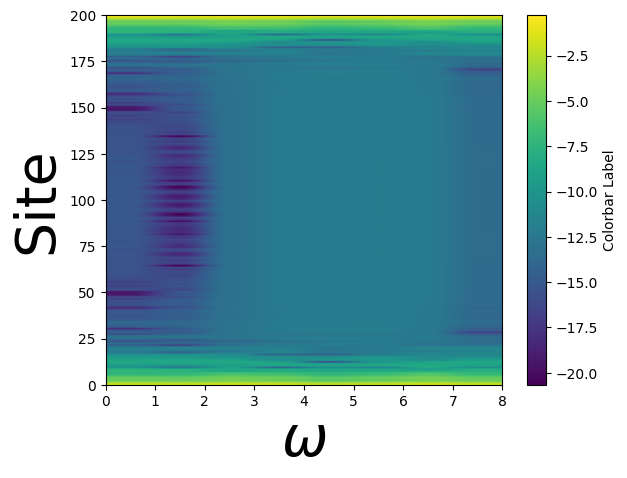

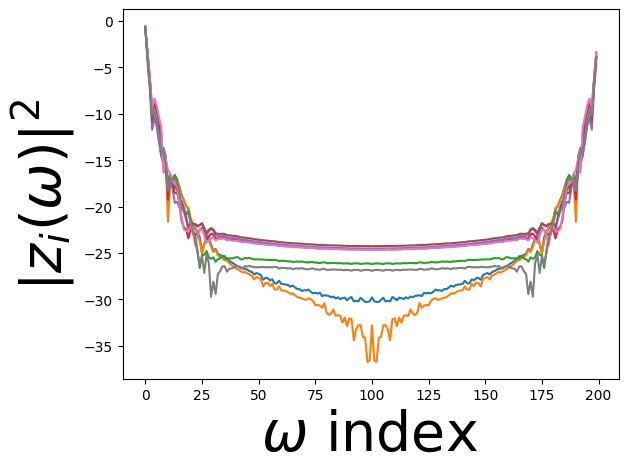

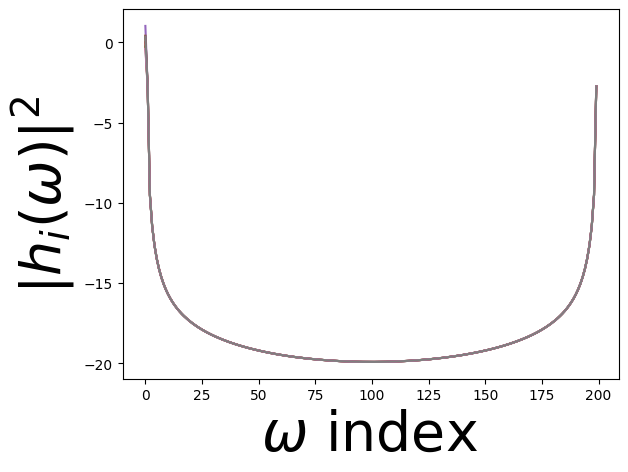

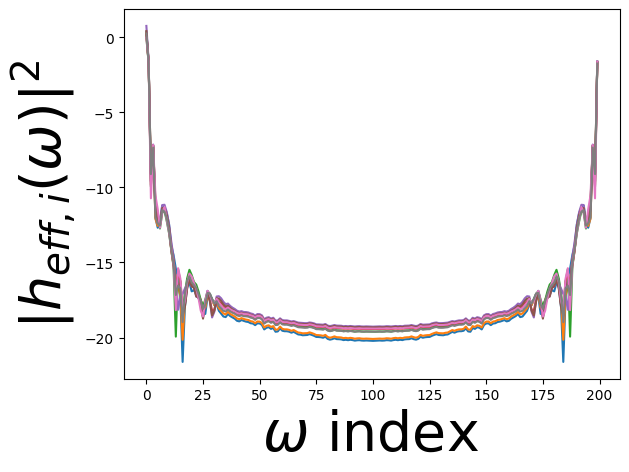

In [7]:


# Create figure and axes
fig, ax = plt.subplots()

# Plot the data
im=ax.imshow(np.log(np.abs(z_fourier[idx,0])), aspect='auto', cmap='viridis', extent=[ 0, 8, 0,200])
print(z_fourier.shape)
# Set labels
ax.set_xlabel(r'$\omega$',fontsize=40)
ax.set_ylabel('Site',fontsize=40)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Colorbar Label')

plt.show()

for i in  range(z_fourier.shape[-1]):
    plt.plot(np.log(z_fourier[idx,0,:,i]**2+z_fourier[idx,1,:,i]**2))
plt.xlabel(r'$\omega$ index ',fontsize=40)
plt.ylabel(r'$|z_i(\omega)|^2$',fontsize=40)
plt.show()

for i in  range(z_fourier.shape[-1]):
    plt.plot(np.log(h_fourier[idx,0,:,i]**2+h_fourier[idx,1,:,i]**2))
plt.xlabel(r'$\omega$ index ',fontsize=40)
plt.ylabel(r'$|h_i(\omega)|^2$',fontsize=40)
plt.show()


for i in  range(z_fourier.shape[-1]):
    plt.plot(np.log(h_eff_fourier[idx,0,:,i]**2+h_eff_fourier[idx,1,:,i]**2))
plt.xlabel(r'$\omega$ index ',fontsize=40)
plt.ylabel(r'$|h_{eff,i}(\omega)|^2$',fontsize=40)
plt.show()



##### Make a dataset based on the Fourier transform

In [8]:
#fix the data
ndata=60000
# fix the file name
file_name=f'train_dataset_fourier_format_240301_ndata_{ndata}'
# permutation
p=np.random.permutation(ndata)
# savez
np.savez('data/dataset_h_eff/'+file_name,density=z_fourier[:ndata][p],potential=h_eff_fourier[:ndata][p],h=h_fourier[:ndata][p])



